In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne import inference

In [2]:
@cirq.transformer
class SubstituteGate:
    """Transformer to substitute `source` gates with `target` in the input circuit."""

    def __init__(self, source, target):
        self._source = source
        self._target = target

    def __call__(self, circuit, *, context=None):
        batch_replace = []
        for i, op in circuit.findall_operations(lambda op: op.gate == self._source):
            batch_replace.append((i, op, self._target.on(*op.qubits)))
        transformed_circuit = circuit.unfreeze(copy=True)
        transformed_circuit.batch_replace(batch_replace)
        return transformed_circuit

substitute_h_inv = SubstituteGate(cirq.H**-1.0,cirq.H)
substitute_cnot_inv = SubstituteGate(cirq.CNOT**-1.0,cirq.CNOT)

In [3]:
def prepare_correlated(env,n=2):
    # yield cirq.H(env[0])
    # yield cirq.H(env[0])
    yield cirq.H(env[1])
    yield cirq.CNOT(env[1],env[0])
    yield cirq.H(env[0])
    yield cirq.H(env[1])

def collide(env,sys,theta):
    yield cirq.CNOT(env,sys)
    yield cirq.rz(rads=2*theta).on(sys)
    yield cirq.CNOT(env,sys)

def collision_pattern_correlated(env,sys,n,theta):
    for i in range(n):
        yield from collide(env[1],sys,theta)

def meas_coherence(sys):
    yield cirq.H(sys)
    yield cirq.measure(sys, key = 'answer')

def collision_circuit(env,sys,n,theta):
    yield cirq.H(sys)
    yield from prepare_correlated(env,n)
    yield from collision_pattern_correlated(env,sys,n,theta)
    yield from meas_coherence(sys)

In [4]:
n = 15
g = 1
tau = np.pi/6
t = np.array(list(range(1,n+1)))*tau
theta = g*tau

def corrfunc(time):
    return (np.cos(time)**2-np.sin(time)**2)/2

sys = cirq.LineQubit(0)
env = cirq.LineQubit.range(1,3)
repcnt = 1024

<hr></hr>

In [5]:
print(cirq.Circuit(collision_circuit(env,sys,3,theta)))

0: ───H───────────X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───H───M('answer')───
                  │                │   │                │   │                │
1: ───────X───H───┼────────────────┼───┼────────────────┼───┼────────────────┼─────────────────────
          │       │                │   │                │   │                │
2: ───H───@───H───@────────────────@───@────────────────@───@────────────────@─────────────────────


In [6]:
#Decomposition of Hadamard into OQC/IBM basis gates
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
had_circuit = cirq.Circuit([cirq.H(q0)])
had_qiskit = QuantumCircuit.from_qasm_str(had_circuit.to_qasm())
had_t = transpile(had_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=0)
print(had_qiskit)
print(had_t)

   ┌───┐
q: ┤ H ├
   └───┘
global phase: π/4
   ┌─────────┐┌────┐┌─────────┐
q: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├
   └─────────┘└────┘└─────────┘


In [7]:
#Decomposition of CNOT into OQC/IBM basis gates
cnot_circuit = cirq.Circuit([cirq.CNOT(q0,q1)])
cnot_qiskit = QuantumCircuit.from_qasm_str(cnot_circuit.to_qasm())
cnot_t = transpile(cnot_qiskit,basis_gates=['rz','sx','x','ecr','id'],optimization_level=1)
print(cnot_qiskit)
print(cnot_t)

          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
global phase: π/2
     ┌──────────┐                ┌──────┐┌───┐
q_0: ┤ Rz(-π/2) ├────────────────┤0     ├┤ X ├
     └┬────────┬┘┌────┐┌────────┐│  Ecr │└───┘
q_1: ─┤ Rz(-π) ├─┤ √X ├┤ Rz(-π) ├┤1     ├─────
      └────────┘ └────┘└────────┘└──────┘     


<hr></hr>

In [8]:
provider = IBMProvider()
backend = provider.get_backend('ibm_kyoto')

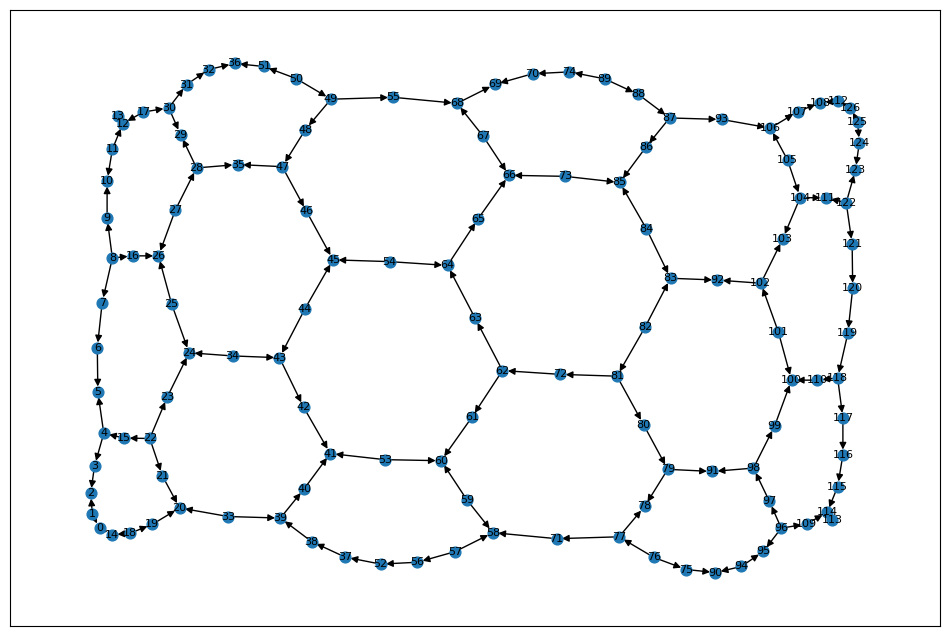

In [9]:
#Run this cell to get a view of the qubit layout
import networkx as nx
G=nx.DiGraph(list(backend.coupling_map))
plt.figure(1,figsize=(12,8)) 
nx.draw_networkx(G,pos=nx.spectral_layout(G),node_size=60,font_size=8)
plt.show()

In [10]:
initial_layout = [0,2,1]

In [11]:
scale_factors = [1,3,5,7]

In [12]:
circ_list = []
for scale_factor in scale_factors:
    for i in range(1,n+1):
        circuit = cirq.Circuit(collision_circuit(env,sys,i,theta))
        circuit_folded = fold_gates_at_random(circuit,scale_factor)
        circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
        circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
        transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
        circ_list.append(transpiled_circuit)

In [13]:
circuit

0: ───H───────────X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───X───Rz(0.333π)───X───H───M('answer')───
                  │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │
1: ───────X───H───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼───┼────────────────┼─────────────────────
          │       │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │   │                │
2: ───H───@───H───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@───@────────────────@─────────────────────

In [14]:
#circ_list[0].draw()

<h2>Circuit depth scaling with number of collisions:</h2>

In [60]:
circ_depth_col = [[],[]]
for i in range(1,n+1):
    circuit = cirq.Circuit(collision_circuit(env,sys,i,theta))
    circuit_qiskit = QuantumCircuit.from_qasm_str(circuit.to_qasm())
    transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0, initial_layout=initial_layout) #,
    circ_depth_col[0].append(len(circuit))
    circ_depth_col[1].append(transpiled_circuit.depth())

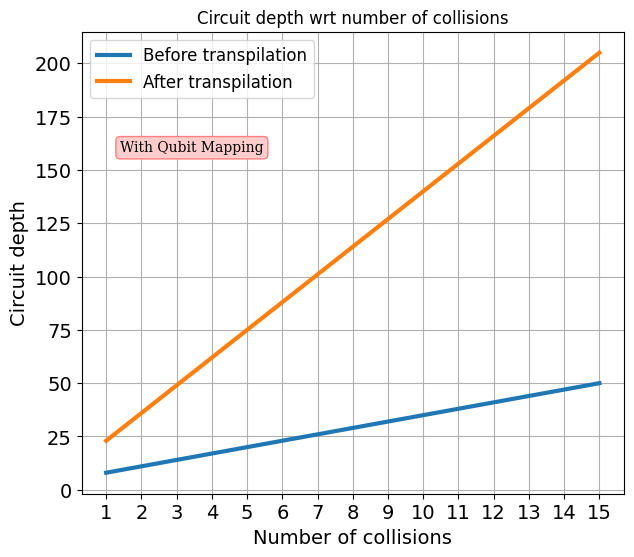

In [61]:
plt.figure(figsize=(7,6))
plt.plot(list(range(1,n+1)),circ_depth_col[0],label='Before transpilation',linewidth = 3)
plt.plot(list(range(1,n+1)),circ_depth_col[1],label='After transpilation',linewidth = 3)
plt.title('Circuit depth wrt number of collisions')
plt.xlabel('Number of collisions',fontsize=14)
plt.ylabel('Circuit depth',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(list(range(1,n+1)),fontsize=14)


plt.figtext(0.18, 0.68 , 'With Qubit Mapping',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)



plt.legend(fontsize=12)
plt.grid()
plt.savefig("qubit_mapping_depth.pdf", bbox_inches='tight', dpi = 300)
plt.show()

<h2>Circuit depth scaling plot:</h2>

In [17]:
from scipy.stats import linregress
from scipy.optimize import curve_fit
def cfit(x,a,b):
    return a*x+b
circ_depth_sca = []
test_depth = 1
for scale_factor in scale_factors:
    circuit = cirq.Circuit(collision_circuit(env,sys,test_depth,theta))
    circuit_folded = fold_gates_at_random(circuit,scale_factor)
    circuit_transformed = substitute_cnot_inv(substitute_h_inv(circuit_folded))
    circuit_qiskit = QuantumCircuit.from_qasm_str(circuit_transformed.to_qasm())
    transpiled_circuit = transpile(circuit_qiskit,backend=backend,optimization_level=0,initial_layout=initial_layout)
    circ_depth_sca.append(transpiled_circuit.depth())
    # circ_depth_sca.append(len(circuit_folded))
popt,pcov = curve_fit(cfit,scale_factors,np.array(circ_depth_sca))

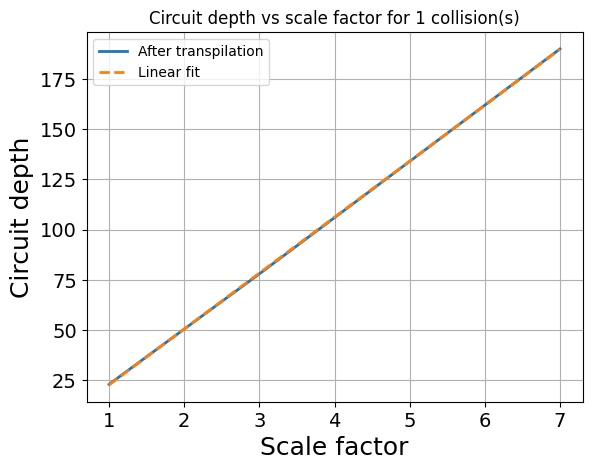

In [43]:
plt.plot(scale_factors,np.array(circ_depth_sca),label='After transpilation',linewidth = 2)
plt.plot(scale_factors,popt[0]*np.array(scale_factors)+popt[1],linestyle='--',label='Linear fit', linewidth = 2)
plt.title(f'Circuit depth vs scale factor for {test_depth} collision(s)')
plt.xlabel('Scale factor',fontsize=18)
plt.ylabel('Circuit depth',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.grid()
plt.show()

<h2>Running job:</h2>

In [20]:
with open('./Jobs/16_victor_15_collisions_kyoto_mapping_[0 2 1]_1024_shots_31_12.txt','x') as job_id_file:
        job = backend.run(circ_list,shots=repcnt)   #Run job
        job_id_file.write(job.job_id()+'\n')    #Write to file
        print('Submitted job with job id '+job.job_id())

print('All complete.')

Submitted job with job id cp8rss7ja3gg0080hb7g
All complete.


In [19]:
def return_counts(job_id,sf):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(sf,2))
    for i in range(sf):
        cnt = counts[i]
        res[i][0] += cnt.get('0',0)
        res[i][1] += cnt.get('1',0)

    return res

In [20]:
def return_counts_scaled(job_id,n,sf,shots):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(n,sf))
    for j in range(sf):
        for i in range(n):
            cnt = counts[j*n+i]
            res[i][j] += 0.5-cnt.get('1',0)/shots

    return res

In [21]:
def mitigate(scale_factors,exp_vals,extrapolation_method):
    mit_val = None
    if extrapolation_method == 'richardson':
        return inference.RichardsonFactory.extrapolate(scale_factors,exp_vals)
    elif extrapolation_method == 'poly2':
        return inference.PolyFactory.extrapolate(scale_factors,exp_vals,2)
    elif extrapolation_method == 'linear':
        return inference.LinearFactory.extrapolate(scale_factors,exp_vals)
    else:
        raise ValueError('Unrecogized extrapolation method')

In [22]:
def improvement_factor(unmit,mit,theory):
    return np.abs((theory-mit)) #(theory-unmit)/

In [24]:
job_id = 'cp3gz4mja3gg0085t8j0'
res = return_counts_scaled(job_id,7,len(scale_factors),repcnt)

In [25]:
res_mit_poly2 = np.array([mitigate(scale_factors,exp_vals,'poly2') for exp_vals in res])
res_mit_richardson = np.array([mitigate(scale_factors,exp_vals,'richardson') for exp_vals in res])
res_mit_linear = np.array([mitigate(scale_factors,exp_vals,'linear') for exp_vals in res])
res_unmit = np.array([exp_vals[0] for exp_vals in res])

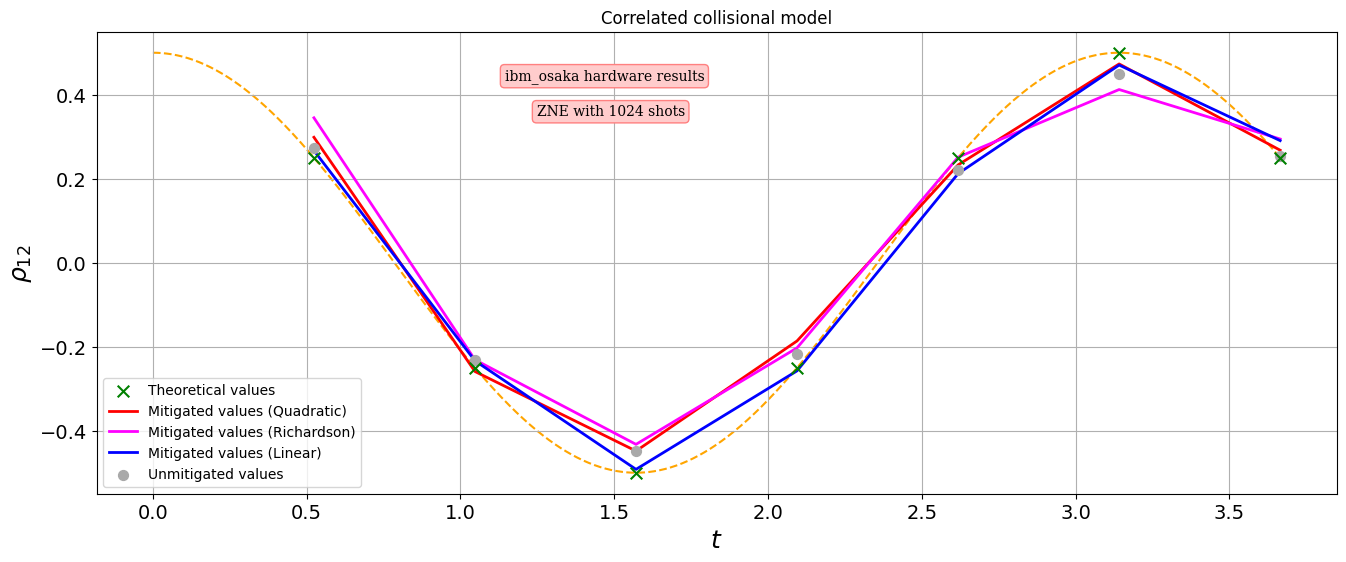

In [33]:
plt.rcParams['text.usetex'] = False
font = {'family': 'serif',
        #'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }

t_pl = (np.array(list(range(1,7+1)))*tau)
x_ax = np.linspace(0,t_pl[-1],num=1000)
plt.figure(figsize=(16,6))
plt.plot(x_ax,corrfunc(x_ax),linestyle='--',c='orange',zorder=0)
plt.scatter(t_pl,corrfunc(t_pl),s=70,label='Theoretical values',marker='x',c='green',zorder=5)

#plt.plot(t_pl,res_unmit,label='Unmitigated values',c='darkgrey',zorder=2,linewidth = 2)
plt.plot(t_pl,res_mit_poly2,label='Mitigated values (Quadratic)',c='red',zorder=3, linewidth = 2)
plt.plot(t_pl,res_mit_richardson,label='Mitigated values (Richardson)',c='magenta',zorder=3, linewidth = 2)
plt.plot(t_pl,res_mit_linear,label='Mitigated values (Linear)',c='blue',zorder=3, linewidth = 2)
plt.scatter(t_pl,res_unmit,s=50,label='Unmitigated values',marker='o',c='darkgrey',zorder=3)
plt.xlabel(r'$t$',fontsize=18)
plt.ylabel(r'$\rho_{12}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Correlated collisional model')

plt.figtext(0.38,0.8 , 'ibm_osaka hardware results',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)

plt.figtext(0.4,0.74 , 'ZNE with 1024 shots',  bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ), fontdict=font)


plt.grid()
plt.legend(fontsize=10)
#plt.gcf().set_size_inches((12.8,4.8))
plt.savefig("collisional_correlated_osaka_1024_shots_final.pdf", bbox_inches='tight', dpi = 400)
plt.show()

0.033553641183035714
0.051749093191964364
0.022453962053571305


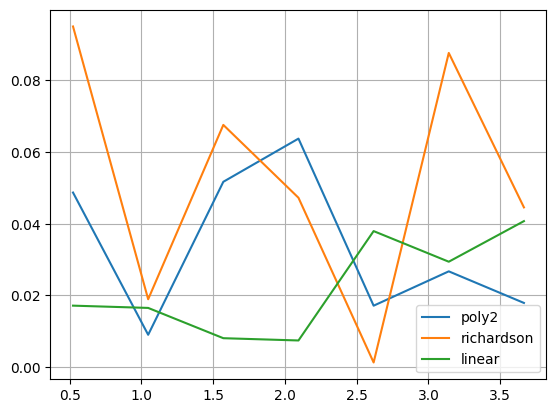

In [27]:
theory = corrfunc(t_pl)
if_poly2 = improvement_factor(res_unmit,res_mit_poly2,theory)
if_richardson = improvement_factor(res_unmit,res_mit_richardson,theory)
if_linear = improvement_factor(res_unmit,res_mit_linear,theory)
print(np.mean(if_poly2))
print(np.mean(if_richardson))
print(np.mean(if_linear))
plt.plot(t_pl,if_poly2,label='poly2')
plt.plot(t_pl,if_richardson,label='richardson')
plt.plot(t_pl,if_linear,label='linear')
plt.grid()
plt.legend()
plt.show()

<h2>Trying readout error mitigation:</h2>

In [29]:
from mitiq.rem import generate_tensored_inverse_confusion_matrix
from mitiq.rem.inverse_confusion_matrix import mitigate_measurements
from mitiq.typing import MeasurementResult

In [33]:
p1_01 = 0.0278 #meas1 prep0
p1_10 = 0.0212 #meas0 prep1
A1 = [[1-p1_10, p1_01],[p1_10,1-p1_01]]
A_pinv = generate_tensored_inverse_confusion_matrix(1, confusion_matrices=[A1])

In [34]:
print(A_pinv)

[[ 1.02229232 -0.02923239]
 [-0.02229232  1.02923239]]


In [35]:
def return_counts_mitigated(job_id,n,sf,shots,inv_conf_mat):
    counts = None
    job = provider.backend.retrieve_job(job_id.strip())
    if not job.done():
        print(job_id.strip()+' is not complete') # to avoid silent fail
        return counts
    results = job.result()
    counts = results.get_counts()
    res = np.zeros(shape=(n,sf))
    for j in range(sf):
        for i in range(n):
            cnt = counts[j*n+i]
            cnt_ms = MeasurementResult.from_counts(cnt)
            cnt_mit = mitigate_measurements(cnt_ms,inv_conf_mat)
            res[i][j] += 0.5-cnt_mit.get_counts().get('1',0)/shots

    return res

In [36]:
res_rem = return_counts_mitigated(job_id,7,len(scale_factors),repcnt,A_pinv)
res_rem_mit_poly2 = np.array([mitigate(scale_factors,exp_vals,'poly2') for exp_vals in res_rem])
res_rem_mit_richardson = np.array([mitigate(scale_factors,exp_vals,'richardson') for exp_vals in res_rem])
res_rem_mit_linear = np.array([mitigate(scale_factors,exp_vals,'linear') for exp_vals in res_rem])
res_rem_unmit = np.array([exp_vals[0] for exp_vals in res_rem])

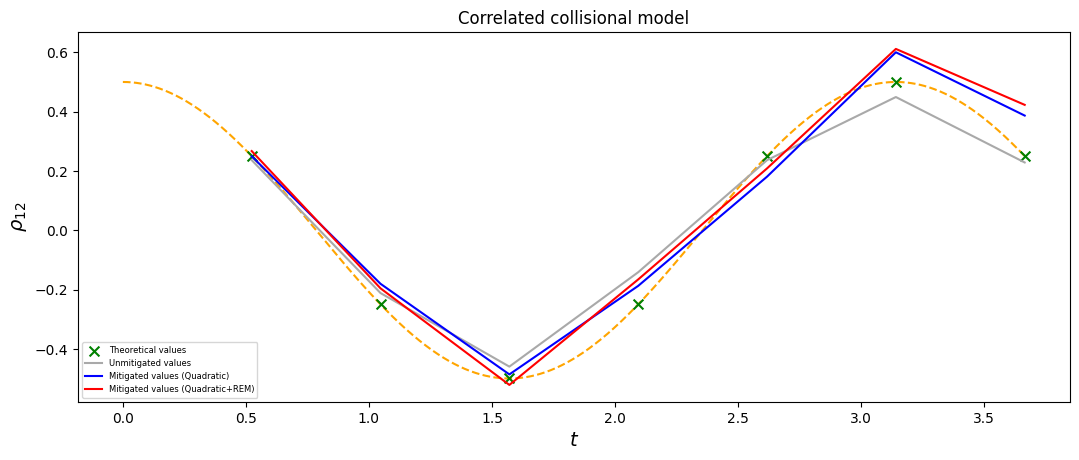

In [37]:
plt.rcParams['text.usetex'] = False
t_pl = (np.array(list(range(1,7+1)))*tau)
x_ax = np.linspace(0,t_pl[-1],num=1000)
plt.plot(x_ax,corrfunc(x_ax),linestyle='--',c='orange',zorder=0)
plt.scatter(t_pl,corrfunc(t_pl),s=50,label='Theoretical values',marker='x',c='green',zorder=1)
plt.plot(t_pl,res_unmit,label='Unmitigated values',c='darkgrey',zorder=2)
plt.plot(t_pl,res_mit_poly2,label='Mitigated values (Quadratic)',c='blue',zorder=3)
plt.plot(t_pl,res_rem_mit_poly2,label='Mitigated values (Quadratic+REM)',c='red',zorder=3)
# plt.plot(t_pl,res_mit_richardson,label='Mitigated values (Richardson)',c='blue',zorder=3)
# plt.plot(t_pl,res_mit_linear,label='Mitigated values (Linear)',c='hotpink',zorder=3)
plt.xlabel(r'$t$',fontsize=14)
plt.ylabel(r'$\rho_{12}$',fontsize=14)
plt.title(r'Correlated collisional model')
plt.legend(fontsize=6)
plt.gcf().set_size_inches((12.8,4.8))
plt.show()